# Run training on preprocessed data

Preprocessing is done by `run/run_ml_prep.py` and `src/core/ml_process.py`

## Training datasets

Signal: `nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020aw_perfect_v1_3_v06_06_00.root`

Background: `nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aw_perfect_v1_3_v06_06_00.root`



In [1]:
import sys
import warnings
warnings.filterwarnings("ignore") # suppress warnings
import pandas as pd
# import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# import uproot
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
# import pickle
# from pathlib import Path
import awkward as ak

sys.path.extend(["../../src/core", "../../src/utils"])
from draw import Draw
from io_manager import Load

## Load data

In [2]:
sig_in_path = "../../output/ml_sig"
bkg_in_path = "../../output/ml_bkg"

sig_data = Load(in_path=sig_in_path).load_pkl()
bkg_data = Load(in_path=bkg_in_path).load_pkl()

[Load] ✅ Initialised with out_path=../../output/ml_sig
[Load] ✅ Successfully loaded results from ../../output/ml_sig/results.pkl
[Load] ✅ Initialised with out_path=../../output/ml_bkg
[Load] ✅ Successfully loaded results from ../../output/ml_bkg/results.pkl


## Verify data

In [3]:
display(sig_data["cut_flow"])
display(bkg_data["cut_flow"])

,Cut,Group,Events Passing,Absolute [%],Relative [%],Description
0,No cuts,NaN,1493499,100.000,100.000,No selection applied
1,has_trk_front,Preselect,1493210,99.981,99.981,Tracks intersect tracker entrance
2,is_reco_electron,Preselect,1491985,99.899,99.918,Electron track fits
3,one_reco_electron,Preselect,1487818,99.620,99.721,One reco electron / event
4,is_downstream,Preselect,1487812,99.619,100.000,Downstream tracks (p_z > 0 at tracker entrance)
5,is_truth_electron,Preselect,1487811,99.619,100.000,Track parents are electrons (truth PID)
6,good_trkqual,Tracker,1352474,90.557,90.904,Track fit quality > 0.2
7,within_t0,Tracker,980647,65.661,72.508,t0 at tracker entrance (640 < t_0 < 1650 ns)


,Cut,Group,Events Passing,Absolute [%],Relative [%],Description
0,No cuts,NaN,2610933,100.000,100.000,No selection applied
1,has_trk_front,Preselect,2558235,97.982,97.982,Tracks intersect tracker entrance
2,is_reco_electron,Preselect,2478213,94.917,96.872,Electron track fits
3,one_reco_electron,Preselect,2051107,78.558,82.766,One reco electron / event
4,is_downstream,Preselect,1127293,43.176,54.960,Downstream tracks (p_z > 0 at tracker entrance)
5,is_truth_electron,Preselect,320796,12.287,28.457,Track parents are electrons (truth PID)
6,good_trkqual,Tracker,253945,9.726,79.161,Track fit quality > 0.2
7,within_t0,Tracker,203326,7.787,80.067,t0 at tracker entrance (640 < t_0 < 1650 ns)


[Load] ✅ Initialised with out_path=test_out
[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[Plot] ⭐️ Initialised
*********************************** SIGNAL ***********************************


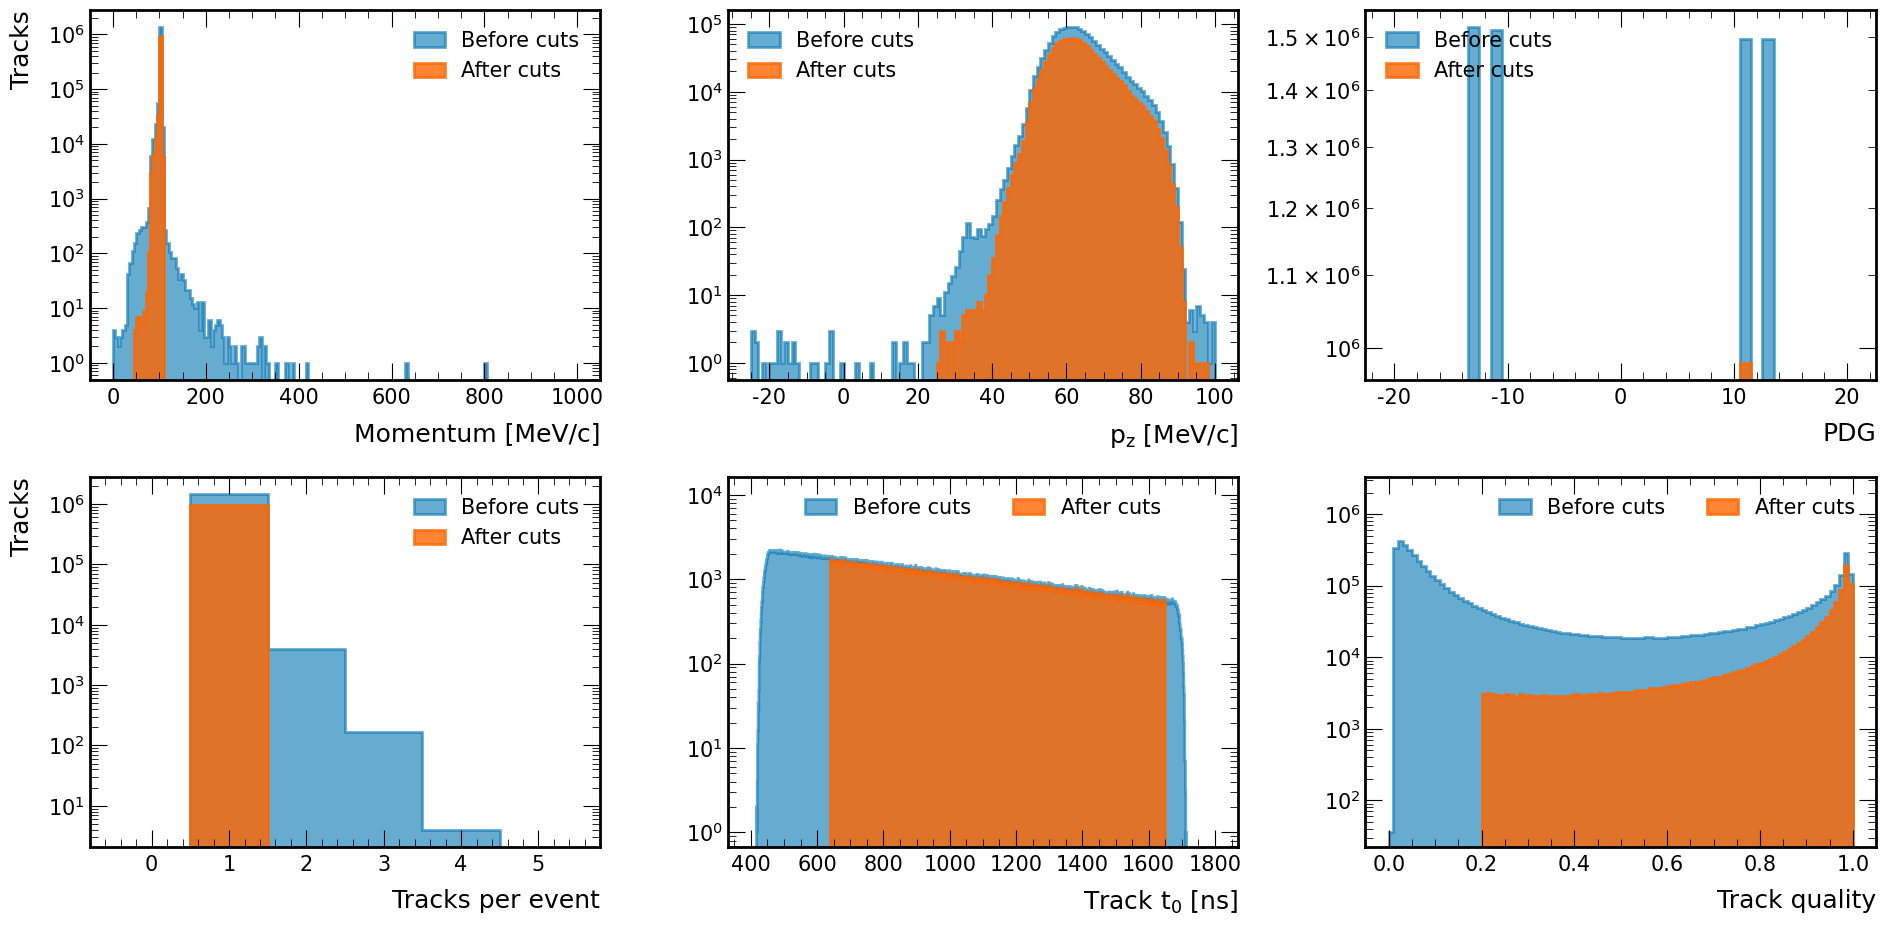

*********************************** BACKGROUND ***********************************


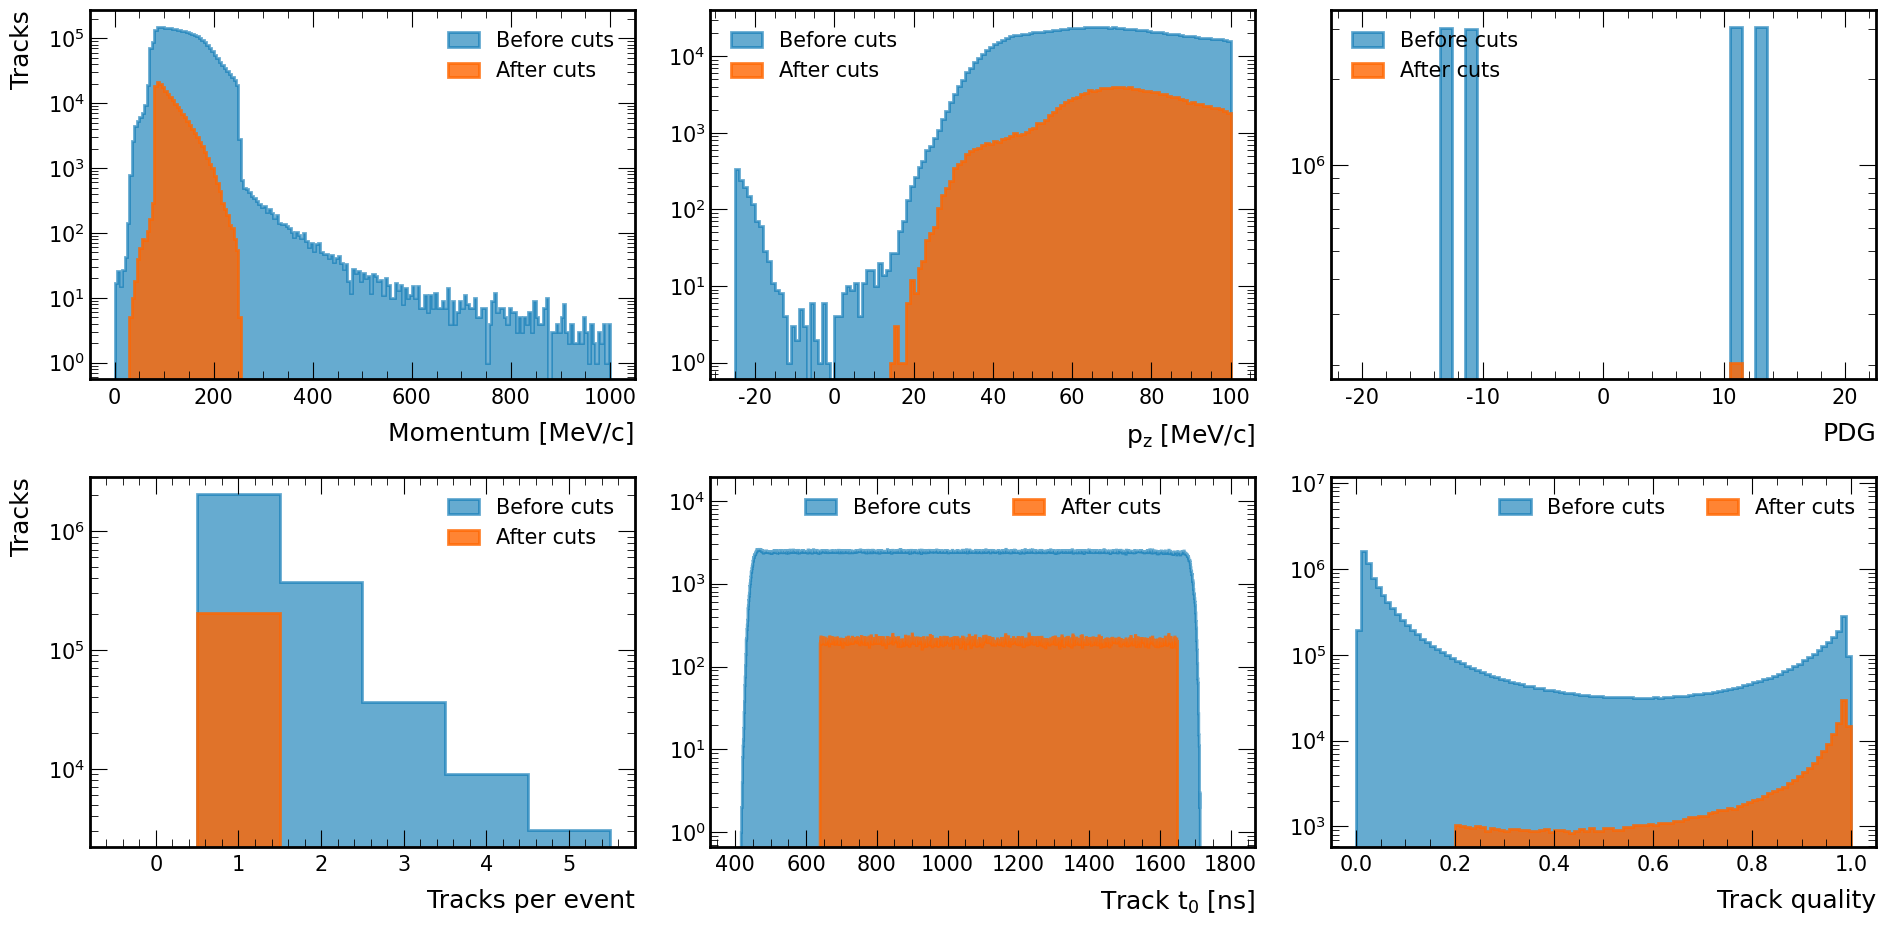

In [4]:
draw = Draw()

print("*"*35, "SIGNAL", "*"*35)
draw.plot_ml_summary(sig_data["hists"])

print("*"*35, "BACKGROUND", "*"*35)
draw.plot_ml_summary(bkg_data["hists"])

In [5]:
print(sig_data["events"].type)
print(bkg_data["events"].type)

980647 * {nactive: int32, t0err: float32, d0: float32, tanDip: float32, maxr: float32}
203326 * {nactive: int32, t0err: float32, d0: float32, tanDip: float32, maxr: float32}


## Training 

In [6]:
# Convert to DataFrame

feature_names = ["nactive", "t0err", "d0", "tanDip", "maxr"]
# feature_names = ["t0err", "d0", "tanDip", "maxr"]

df_sig = ak.to_dataframe(sig_data["events"])
df_bkg = ak.to_dataframe(bkg_data["events"])

df_sig['label'] = 1
df_bkg['label'] = 0

# display(signal_df)
# display(bkg_data)

In [7]:
# Combine and shuffle, why?
df_train = pd.concat([df_sig, df_bkg], ignore_index=True)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
display(df_train)

,nactive,t0err,d0,tanDip,maxr,label
0,63,0.428916,57.088078,0.591628,628.251587,1
1,58,0.408326,222.161911,0.954052,608.521057,0
2,57,0.405947,110.867874,1.593542,589.830872,0
3,33,0.450032,40.529434,0.759309,482.940125,1
4,62,0.416622,38.685398,0.658637,597.931763,1
...,...,...,...,...,...,...
1183968,38,0.442987,71.200096,0.979107,553.594788,1
1183969,43,0.444610,18.446339,0.618925,544.823853,1
1183970,41,0.447440,13.091311,0.692259,562.031311,1
1183971,29,0.448754,23.516546,0.710111,524.939514,1


In [8]:
X = df_train.drop('label', axis=1)
y = df_train['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining: {len(X_train)} events")
print(f"Test: {len(X_test)} events")


Training: 947178 events
Test: 236795 events


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled")

✅ Features scaled


In [10]:
print("\n🚀 Training XGBoost model...")

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model.fit(X_train_scaled, y_train)

print("✅ Training complete!")


🚀 Training XGBoost model...
✅ Training complete!


In [11]:
train_pred = model.predict_proba(X_train_scaled)[:, 1]
test_pred = model.predict_proba(X_test_scaled)[:, 1]

train_auc = roc_auc_score(y_train, train_pred)
test_auc = roc_auc_score(y_test, test_pred)

print(f"\nTraining AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Training AUC: 0.9865
Test AUC: 0.9859


In [15]:
print("\nFeature importance:") 
for feat, imp in zip(feature_names, model.feature_importances_):
    print(f"  {feat:10s}: {imp:.4f}")


Feature importance:
  nactive   : 0.0117
  t0err     : 0.0013
  d0        : 0.7272
  tanDip    : 0.0826
  maxr      : 0.1772


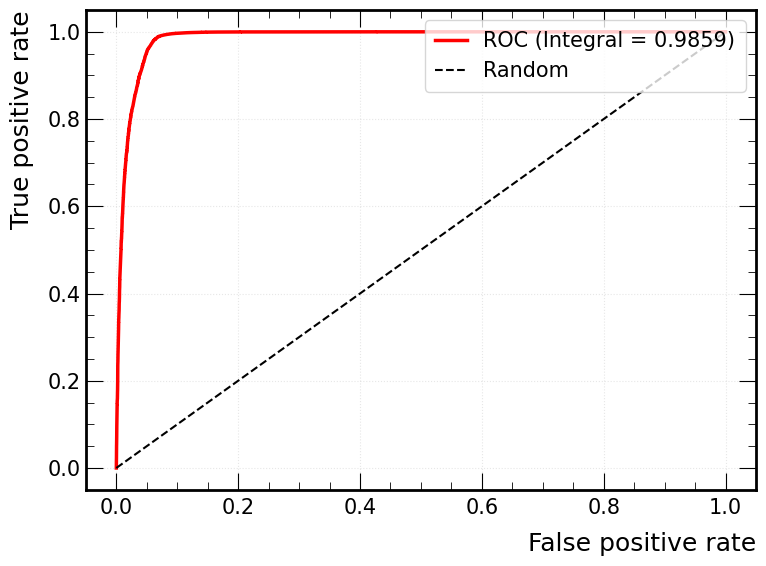


✅ Done! ROC curve saved to roc_curve.png


In [17]:
fpr, tpr, _ = roc_curve(y_test, test_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2.5, label=f'ROC (Integral = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=150)
plt.show()

print("\n✅ Done! ROC curve saved to roc_curve.png")

ImportError: You must install graphviz to plot tree

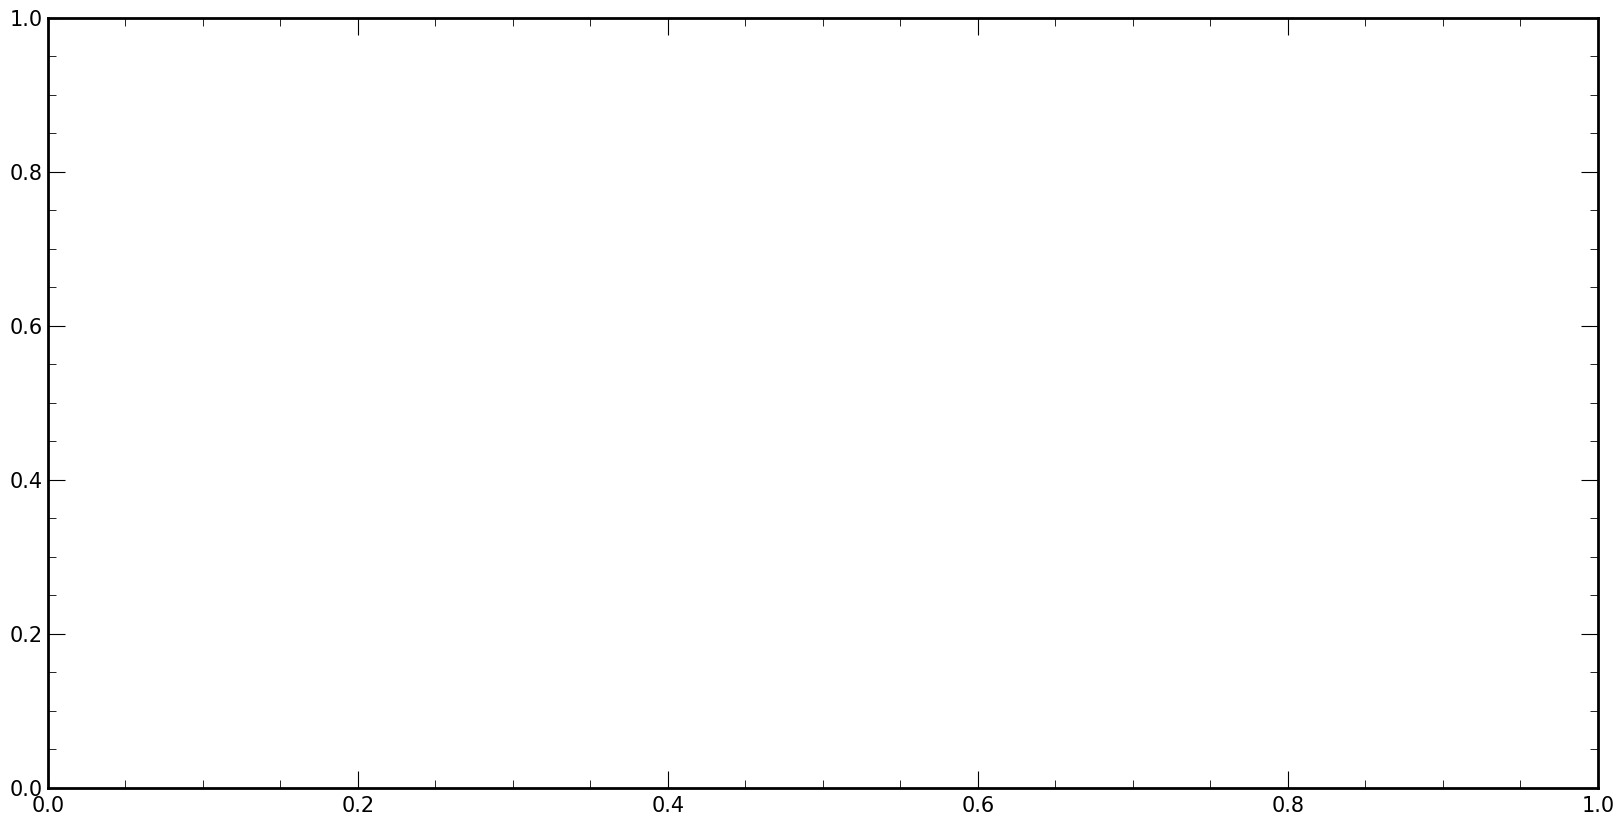

In [16]:
# import matplotlib.pyplot as plt
# from xgboost import plot_tree

# # Plot the first tree
# fig, ax = plt.subplots(figsize=(20, 10))
# plot_tree(model, num_trees=0, ax=ax)  # First tree
# plt.title('First Decision Tree in XGBoost Ensemble')
# plt.tight_layout()
# plt.savefig('xgboost_tree.png', dpi=150)
# plt.show()

# # Plot the most important tree (around tree 10-20 usually best)
# fig, ax = plt.subplots(figsize=(20, 10))
# plot_tree(model, num_trees=10, ax=ax)
# plt.title('Tree #10 in XGBoost Ensemble')
# plt.tight_layout()
# plt.savefig('xgboost_tree_10.png', dpi=150)
# plt.show()